# Temperature Profile
This compares the temperature profile conditioned on a given quantile to the strict convective equilibrium profile.

In [18]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.convection.base import convection_neutral_profile, lcl_temp_bolton, dry_profile_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms,mse_mod_anom_change_ft_expansion, mse_mod_change_surf_expansion, \
    get_scaling_factor_theory, get_temp_adiabat
import matplotlib.patheffects as mpe
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [48]:
# Load dataset
use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)

# Load dataset
tau_lw_ref = 0.6
tau_lw_warm = 1.5
# refer to bucket model with vegetation as bucket
# Don't include actual bucket, as looks very similar to bucket with vegetation param
# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
# exp_dir = 'tau_sweep/aquaplanet/depth=1/'
# exp_dir = 'tau_sweep/aquaplanet/depth=1/ras_conv/'

# only keep variables required to compute relative humidity and MSE
if 'ras_conv' in exp_dir:
    var_keep = ['temp', 'sphum', 'height']
else:
    var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag']

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']

kappa_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_kappa = len(kappa_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = isca_tools.load_dataset(exp_dir + kappa_names[j]).sel(time=slice(use_time_start, np.inf))[var_keep]
        ds += [ds_use]      # only keep the surface and free troposphere values
        namelist = isca_tools.load_namelist(exp_dir + kappa_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        pbar.update(1)
        
pfull = ds[0].pfull         # pfull must be ascending i.e. pfull[0] is space
ind_surf = int(np.abs(pfull-1000000).argmin())
ind_ft = int(np.abs(pfull-pressure_ft).argmin())
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = pfull.size
lnp_const = R * np.log(p_surface/pressure_ft_actual)/2      # for modified MSE calculation

  0%|          | 0/2 [00:00<?, ?it/s]/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 25 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
 50%|█████     | 1/2 [00:01<00:01,  1.36s/it]/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 25 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the all or just tbe summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [49]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

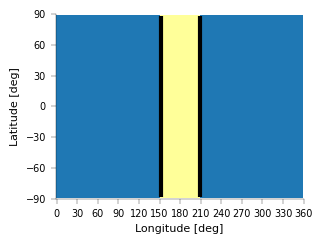

In [50]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, kappa_names[0], 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land
    
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [51]:
# Load in across all latitudes, for given season

# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# lat_max = 90

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'
# season = 'winter'
if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}   
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]} 

lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
n_lat = len(lat_use_ind)
lat_weights = np.cos(np.deg2rad(ds[0].lat))[lat_use_ind]

# Whether to do taylor expansion about mean over just land or mean over whole planet
mean_method = 'land'
# mean_method = 'all'

temp_surf_mean = np.zeros((n_kappa, n_lat))
temp_ft_mean = np.zeros((n_kappa, n_lat))
z_surf_mean = np.zeros((n_kappa, n_lat))
z_ft_mean = np.zeros((n_kappa, n_lat))

# Decide how to compute humidities - do q first and then r from this ('sphum'), or vice versa ('r')?
humidity_calc_method = 'sphum'
if humidity_calc_method == 'sphum':
    sphum_mean = np.zeros((n_kappa, n_lat))
elif humidity_calc_method == 'r':
    r_mean = np.zeros((n_kappa, n_lat))
else:
    raise ValueError(f'humidity_calc_method of {humidity_calc_method} not valid')

ds_all = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds[j].isel(lat=lat_use_ind)   # only keep latitudes being used to save memory
        if is_land_data:
            # if not aquaplanet, then is land and only consider land longitudes
            ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])
        
        if season == 'summer':
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        
        if mean_method == 'all':
            ds_use = ds[j].sel(time=slice(use_time_start, np.inf)).isel(lat=lat_use_ind)
            ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        elif mean_method != 'land':
            raise ValueError(f'Mean method is {mean_method} which is not valid.')
        ds_use = ds_use.isel(pfull=[ind_surf, ind_ft])       # find mean at surface and ft
        temp_surf_mean[j] = ds_use.temp.isel(pfull=0).mean(dim='lon_time')
        temp_ft_mean[j] = ds_use.temp.isel(pfull=-1).mean(dim='lon_time')
        z_surf_mean[j] = ds_use.height.isel(pfull=0).mean(dim='lon_time')
        z_ft_mean[j] = ds_use.height.isel(pfull=-1).mean(dim='lon_time')
        if humidity_calc_method == 'r':
            rh_use = ds_use.sphum.isel(pfull=0)/sphum_sat(ds_use.temp.isel(pfull=0), p_surface)
            r_mean[j] = rh_use.mean(dim='lon_time')
        else:
            sphum_mean[j] = ds_use.sphum.isel(pfull=0).mean(dim='lon_time')
        pbar.update(1)
if humidity_calc_method == 'r':
    sphum_mean = r_mean * sphum_sat(temp_surf_mean, p_surface)       # compute sphum_mean from r_mean
else:
    r_mean = sphum_mean / sphum_sat(temp_surf_mean, p_surface)

100%|██████████| 2/2 [00:13<00:00,  6.69s/it]


In [52]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
percentile_label = 'Temperature percentile, $x$'

# Days must have klzb < thresh and convflag > thresh to be considered convecting.
klzb_thresh = 13
convflag_thresh = 1

temp_surf_quant3 = np.zeros((n_kappa, n_lat, n_quant))
temp_ft_quant3 = np.zeros((n_kappa, n_lat, n_quant))
if humidity_calc_method == 'r':
    # relative humidity as function of temp quantile not temp quantile
    r_quant3 = np.zeros((n_kappa, n_lat, n_quant))
elif humidity_calc_method == 'sphum':
    sphum_quant3 = np.zeros((n_kappa, n_lat, n_quant))
z_surf_quant3 = np.zeros((n_kappa, n_lat, n_quant))
z_ft_quant3 = np.zeros((n_kappa, n_lat, n_quant))
convflag_quant3 = np.zeros((n_kappa, n_lat, n_quant))
klzbs_quant3 = np.zeros((n_kappa, n_lat, n_quant))
convfract_quant3 = np.zeros((n_kappa, n_lat, n_quant))            # record fraction of days convecting

with tqdm(total=n_kappa*n_quant*n_lat, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds_all[j].isel(pfull=[ind_surf, ind_ft])
        rh_use = ds_use.sphum.isel(pfull=0)/sphum_sat(ds_use.temp.isel(pfull=0), p_surface)
        if 'klzbs' in var_keep:
            is_convecting = np.logical_and(ds_use.klzbs<klzb_thresh, ds_use.convflag > convflag_thresh)
        for k in range(n_lat):
            for q, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_use.temp[0, k], quant, 0.5, 0.5)
                temp_surf_quant3[j, k, q] = ds_use.temp[0, k, use_ind].mean(dim='lon_time')
                temp_ft_quant3[j, k, q] = ds_use.temp[-1, k, use_ind].mean(dim='lon_time')
                z_surf_quant3[j, k, q] = ds_use.height[0, k, use_ind].mean(dim='lon_time')
                z_ft_quant3[j, k, q] = ds_use.height[-1, k, use_ind].mean(dim='lon_time')
                
                if humidity_calc_method == 'r':
                    r_quant3[j, k, q] = rh_use[k, use_ind].mean(dim='lon_time')
                elif humidity_calc_method == 'sphum':
                    sphum_quant3[j, k, q] = ds_use.sphum.isel(pfull=0)[k, use_ind].mean(dim='lon_time')
                
                if 'klzbs' in var_keep:
                    convflag_quant3[j, k, q] = ds_use.convflag[k, use_ind].mean(dim='lon_time')
                    klzbs_quant3[j, k, q] = ds_use.klzbs[k, use_ind].mean(dim='lon_time')
                    convfract_quant3[j, k, q] = np.sum(is_convecting[k, use_ind])/is_convecting[k, use_ind].size
                pbar.update(1)

if humidity_calc_method == 'r':
    sphum_quant3 = sphum_sat(temp_surf_quant3, p_surface) * r_quant3 
elif humidity_calc_method == 'sphum':
    r_quant3 = sphum_quant3 / sphum_sat(temp_surf_quant3, p_surface)
r_anom = r_quant3 - r_mean[:, :, np.newaxis]
temp_surf_anom = temp_surf_quant3 - temp_surf_mean[:, :, np.newaxis]
temp_ft_anom = temp_ft_quant3 - temp_ft_mean[:, :, np.newaxis]

100%|██████████| 2772/2772 [00:09<00:00, 301.62it/s]


## Temperature profile conditioned on $x$
Here I get the mean temperature profile for a given quantile, and see how it changes with warming.

In [53]:
# quant_use_profile = [10, 99]
quant_use_profile = [1, 99]
# quant_use_profile = [1, 50, 99]
# quant_use_profile = [1, 30]
# quant_use_profile = [20, 80]
quant_use_profile_ind = numpy_indexed.indices(quant_plot, quant_use_profile)
n_profiles = len(quant_use_profile)
temp_profile = np.zeros((n_kappa, n_lat, n_profiles, n_pressure))
z_profile = np.zeros((n_kappa, n_lat, n_profiles, n_pressure))
lapse_rate = np.zeros((n_kappa, n_lat, n_profiles, n_pressure))         # in K/km
for i in range(n_kappa):
    for j in range(n_lat):
        for k in range(n_profiles):
            use_ind = get_quant_ind(ds_all[i].temp[ind_surf, j], quant_use_profile[k], 0.5, 0.5)
            temp_profile[i, j, k] = ds_all[i].temp[:, j, use_ind].mean(dim='lon_time')
            z_profile[i, j, k] = ds_all[i].height[:, j, use_ind].mean(dim='lon_time')
            lapse_rate[i, j, k] = -np.gradient(temp_profile[i, j, k], z_profile[i, j, k]) * 1000

In [54]:
pressure_from_level_func = scipy.interpolate.interp1d(np.arange(len(ds[0].pfull)), ds[0].pfull)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

In [55]:
temp_lcl = np.zeros((n_kappa, n_lat, n_profiles))
pressure_lcl = np.zeros((n_kappa, n_lat, n_profiles))
pressure_lzb = np.zeros((n_kappa, n_lat, n_profiles))
temp_profile_conv = np.zeros((n_kappa, n_lat, n_profiles, n_pressure))
lapse_rate_conv = np.zeros((n_kappa, n_lat, n_profiles, n_pressure))         # in K/km
for i in range(n_kappa):
    for j in range(n_lat):
        for k in range(n_profiles):
            temp_lcl[i, j, k] = lcl_temp_bolton(temp_surf_quant3[i, j, quant_use_profile_ind[k]], r_quant3[i, j, quant_use_profile_ind[k]]*100)
            pressure_lcl[i, j, k] = dry_profile_pressure(temp_surf_quant3[i, j, quant_use_profile_ind[k]], p_surface, temp_lcl[i, j, k])/100
            if 'klzbs' in var_keep:
                pressure_lzb[i, j, k] = lzb(klzbs_quant3[i, j, quant_use_profile_ind[k]])
            temp_profile_conv[i, j, k] = convection_neutral_profile(temp_surf_quant3[i, j, quant_use_profile_ind[k]], p_surface, 
                                                                 temp_lcl[i, j, k], pfull*100)
            lapse_rate_conv[i, j, k] = -np.gradient(temp_profile_conv[i, j, k], z_profile[i, j, k]) * 1000

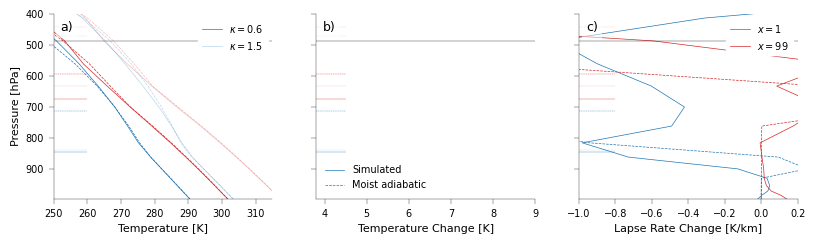

In [56]:
colors_profile = [default_colors[0], default_colors[3]]
colors_conv = ['k', default_colors[1]]

save_temp_profile_fig = True
fig, ax = plt.subplots(1,3, figsize=(3*width['one_col'], width['one_col']/ar), sharey=True)
# pe1 = [[mpe.Stroke(linewidth=0.8, foreground='black'),
#        mpe.Stroke(foreground='white',alpha=1),
#        mpe.Normal()], None]
opacity_kappa = [1, 0.3]
# pe1_lcl = [[mpe.Stroke(linewidth=0.8, foreground='black', alpha=0.3),
#        mpe.Stroke(foreground='white',alpha=1),
#        mpe.Normal()], None]
plcl_xlims = [[0, 260], [0, 4.5], [-10, -0.8]]
# plcl_xlims = [[[0, 295], [4.8, 60], [-10, 10]], 
#               [[295, 330], [3.8, 4.8], [-10, 10]]]
x_var_shift = [0, 10]
x_var_shift = [0, 0]
for k in range(n_profiles):
    for i in range(n_kappa):
        ax[0].plot(np.average(temp_profile[i, :, k], axis=0, weights=lat_weights)+x_var_shift[k], pfull, color=colors_profile[k], 
                   alpha=opacity_kappa[i], label=f'$\kappa={tau_lw[i]}$' if k==0 else None)
        ax[0].plot(np.average(temp_profile_conv[i, :, k], axis=0, weights=lat_weights)+x_var_shift[k], pfull, color=colors_profile[k], linestyle='--',
           alpha=opacity_kappa[i])
        for j in range(len(ax)):
            ax[j].hlines(np.average(pressure_lcl[i, :, k], axis=0, weights=lat_weights), plcl_xlims[j][0], plcl_xlims[j][1], 
                         color=colors_profile[k], alpha=opacity_kappa[i], lw=ax_linewidth)
            ax[j].hlines(np.average(pressure_lzb[i, :, k], axis=0, weights=lat_weights), plcl_xlims[j][0], plcl_xlims[j][1], 
                         color=colors_profile[k], linestyle='--', alpha=opacity_kappa[i], lw=ax_linewidth)
    ax[1].plot(np.average(temp_profile[1, :, k]-temp_profile[0, :, k], axis=0, weights=lat_weights), pfull, 
               color=colors_profile[k], label='Simulated' if k==0 else None)
    ax[1].plot(np.average(temp_profile_conv[1, :, k]-temp_profile_conv[0, :, k], axis=0, weights=lat_weights), pfull, 
               color=colors_profile[k], linestyle='--', label='Moist adiabatic' if k==0 else None)
    ax[2].plot(np.average(lapse_rate[1, :, k]-lapse_rate[0, :, k], axis=0, weights=lat_weights), pfull, 
               color=colors_profile[k], label=f'$x={quant_use_profile[k]}$')
    ax[2].plot(np.average(lapse_rate_conv[1, :, k]-lapse_rate_conv[0, :, k], axis=0, weights=lat_weights), pfull, 
               color=colors_profile[k], linestyle='--')
ax[0].invert_yaxis()
ax[0].legend(loc='upper right', frameon=True, framealpha=1, edgecolor='w')
ax[1].legend(frameon=True, framealpha=1, edgecolor='w')
ax[2].legend(loc='upper right', frameon=True, framealpha=1, edgecolor='w')
ax[0].set_ylim(p_surface/100, 400)
ax[0].set_xlim(250, 315)
ax[0].set_ylabel('Pressure [hPa]')
ax[0].set_xlabel('Temperature [K]')
ax[1].set_xlabel('Temperature Change [K]')
ax[2].set_xlabel('Lapse Rate Change [K/km]')
ax[1].set_xlim(3.8, 9)
ax[2].set_xlim(-1, 0.2)
for j in range(3):
    ax[j].axhline(pressure_ft_actual/100, color='k', lw=ax_linewidth)
label_subplots(fig, ax, box_alpha=0.5)
if save_temp_profile_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_profile_{region}_{season}.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

<xarray.DataArray 'klzbs' (lat: 14, lon_time: 37800)> Size: 529kB
array([[False, False, False, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    time     (lon_time) float64 302kB 720.5 721.5 722.5 ... 2.518e+03 2.52e+03
    lon      (lon_time) float64 302kB 151.9 151.9 151.9 ... 208.1 208.1 208.1
  * lat      (lat) float64 112B -18.14 -15.35 -12.56 ... 12.56 15.35 18.14
Dimensions without coordinates: lon_time

In [39]:
temp_a_quant3 = np.zeros((n_kappa, n_lat, n_quant))
for i in range(n_kappa):
    for j in range(n_lat):
        for k in range(n_quant):
            temp_a_quant3[i, j, k] = get_temp_adiabat(temp_surf_quant3[i, j, k], sphum_quant3[i, j, k], p_surface, pressure_ft_actual)
epsilon_quant3 = moist_static_energy(temp_surf_quant3, sphum_quant3, z_surf_quant3) - \
                 moist_static_energy(temp_ft_quant3, sphum_sat(temp_ft_quant3, pressure_ft_actual), z_ft_quant3)

/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_68362/1735775048.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  temp_a_quant3[i, j, k] = get_temp_adiabat(temp_surf_quant3[i, j, k], sphum_quant3[i, j, k], p_surface, pressure_ft_actual)


## WTG vs Convection Influence
Below I plot the FT and Adiabatic temperature vs near-surface percentile. It is clear, when I use all days not just summer that WTG keeps gradient small for low $x$, but convection sets the profile for large $x$.

I also plot the temperature profiles, showing that the $x=1$ profile transitions to the $x=50$ profile above the LCL.

In [12]:
# temp_surf_summer = np.average(temp_surf_quant3, axis=1, weights=lat_weights)
# temp_ft_summer = np.average(temp_ft_quant3, axis=1, weights=lat_weights)
# temp_a_summer = np.average(temp_a_quant3, axis=1, weights=lat_weights)
# epsilon_diff_summer = np.average(epsilon_quant3[1] - epsilon_quant3[0], axis=0, weights=lat_weights)

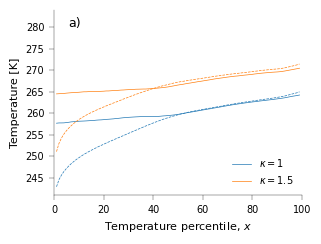

In [13]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_kappa):
    ax.plot(quant_plot, np.average(temp_ft_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
    ax.plot(quant_plot, np.average(temp_a_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], linestyle='--')
# for i in range(n_kappa):
#     ax.plot(quant_plot, temp_ft_summer[i]+10, color=default_colors[i], alpha=0.3)
#     ax.plot(quant_plot, temp_a_summer[i]+10, color=default_colors[i], linestyle='--', alpha=0.3)
ax.set_xlim(0, 100)
ax.set_xlabel(percentile_label)
ax.set_ylim(241, 284)
ax.set_ylabel('Temperature [K]')
ax.legend(loc='lower right')
label_subplots(fig, ax, box_alpha=0)
# fig.savefig(f"/Users/joshduffield/Desktop/temp_ft.pdf",
#                 dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

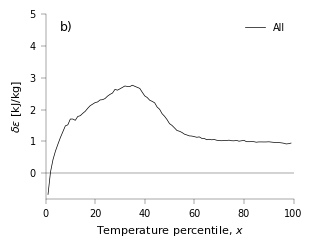

In [14]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average(epsilon_quant3[1] - epsilon_quant3[0], axis=0, weights=lat_weights), color='k', label='All')
# ax.plot(quant_plot, epsilon_diff_summer, color='k', alpha=0.3, label='Summer')
ax.legend()
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlim(0, 100)
ax.set_xlabel(percentile_label)
ax.set_ylabel('$\delta \epsilon$ [kJ/kg]')
ax.legend(frameon=True, framealpha=1, edgecolor='white')
ax.set_ylim(-0.8, 5)
label_subplots(fig, [ax], ['b)'])
# fig.savefig(f"/Users/joshduffield/Desktop/e_change.pdf",
#                 dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

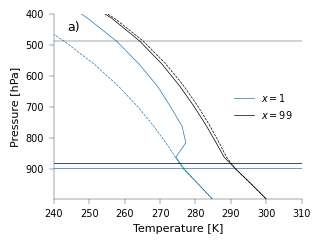

In [15]:
colors_use = [default_colors[0], 'k', default_colors[3]]
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
for k in range(n_profiles):
    ax.plot(np.average(temp_profile[0, :, k], axis=0, weights=lat_weights), pfull, color=colors_use[k], label=f'$x={quant_use_profile[k]}$')
    ax.plot(np.average(temp_profile_conv[0, :, k], axis=0, weights=lat_weights), pfull, color=colors_use[k], linestyle='--')
    ax.axhline(np.average(pressure_lcl[0, :, k], axis=0, weights=lat_weights), 
                         color=colors_use[k])
ax.invert_yaxis()
ax.set_ylim(p_surface/100, 400)
ax.set_xlim(240, 310)
ax.axhline(pressure_ft_actual/100, color='k', lw=ax_linewidth)
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Pressure [hPa]')
ax.legend(frameon=True, framealpha=1, edgecolor='w')
label_subplots(fig, [ax], ['b)'] if is_land_data else None, box_alpha=0)
# fig.savefig(f"/Users/joshduffield/Desktop/temp_profile_{season}.pdf",
#                 dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

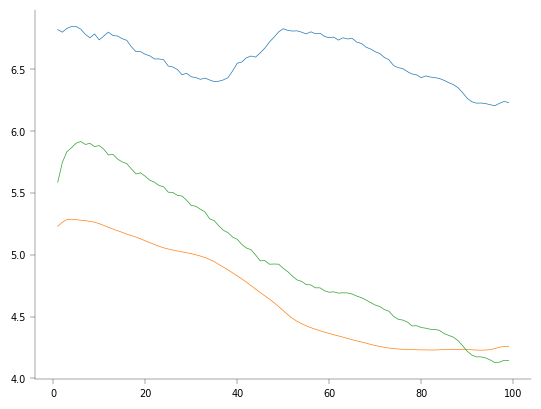

In [16]:
temp_lcl_quant = lcl_temp_bolton(temp_surf_quant3, r_quant3*100)
plt.plot(quant_plot, np.average(temp_ft_quant3[1]-temp_ft_quant3[0], axis=0, weights=lat_weights))
plt.plot(quant_plot, np.average(temp_surf_quant3[1]-temp_surf_quant3[0], axis=0, weights=lat_weights))
plt.plot(quant_plot, np.average(temp_lcl_quant[1]-temp_lcl_quant[0], axis=0, weights=lat_weights))

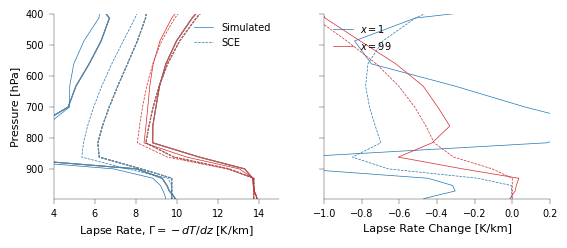

In [17]:
save_lapse_fig = False
fig, ax = plt.subplots(1,2, figsize=(2*width['one_col'], width['one_col']/ar), sharey=True)
pe1 = [[mpe.Stroke(linewidth=0.8, foreground='black'),
       mpe.Stroke(foreground='white',alpha=1),
       mpe.Normal()], None]
plcl_xlims = [[[0, 295], [4.8, 60]], 
              [[295, 330], [3.8, 4.8]]]
x_var_shift = [0, 4]
for k in range(n_profiles):
    for i in range(n_kappa):
        ax[0].plot(np.average(lapse_rate[i, :, k], axis=0, weights=lat_weights)+x_var_shift[k], pfull, color=colors_profile[k], 
                   path_effects=pe1[i], label='Simulated' if i==1 and k==0 else None)
        ax[0].plot(np.average(lapse_rate_conv[i, :, k], axis=0, weights=lat_weights)+x_var_shift[k], pfull, color=colors_profile[k], linestyle='--',
           path_effects=pe1[i], label='SCE' if i==1 and k==0 else None)
        # for j in range(len(ax)):
        #     ax[j].hlines(np.average(pressure_lcl[i, :, k], axis=0, weights=lat_weights), plcl_xlims[k][j][0], plcl_xlims[k][j][1], 
        #                  path_effects=pe1[i], color=colors_profile[k])
        #     ax[j].hlines(np.average(pressure_lzb[i, :, k], axis=0, weights=lat_weights), plcl_xlims[k][j][0], plcl_xlims[k][j][1], 
        #                  path_effects=pe1[i], color=colors_profile[k], linestyle='--')
    ax[1].plot(np.average(lapse_rate[1, :, k]-lapse_rate[0, :, k], axis=0, weights=lat_weights), pfull, 
               color=colors_profile[k], label=f'$x={quant_use_profile[k]}$')
    ax[1].plot(np.average(lapse_rate_conv[1, :, k]-lapse_rate_conv[0, :, k], axis=0, weights=lat_weights), pfull, 
               color=colors_profile[k], linestyle='--')
ax[0].invert_yaxis()
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper left')
ax[0].set_ylim(p_surface/100, 400)
ax[0].set_xlim(4, 15)
ax[1].set_xlim(-1, 0.2)
ax[0].set_ylabel('Pressure [hPa]')
ax[0].set_xlabel('Lapse Rate, $\Gamma=-dT/dz$ [K/km]')
ax[1].set_xlabel('Lapse Rate Change [K/km]')
# ax[1].set_xlim(3.8, 9)
if save_lapse_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lapse_rate_{region}_{season}.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [18]:
sf_simulated = (temp_surf_quant3[1] - temp_surf_quant3[0]) / (temp_surf_mean[1] - temp_surf_mean[0])[:, np.newaxis]
sf_theory = np.zeros((n_lat, n_quant))
for i in range(n_lat):
    sf_theory[i] = get_scaling_factor_theory(temp_surf_mean[:, i], temp_surf_quant3[:, i], sphum_mean[:, i], sphum_quant3[:, i], 
                                             p_surface, pressure_ft_actual, temp_ft_mean[:, i], temp_ft_quant3[:, i], z_ft_mean[:, i], 
                                             z_ft_quant3[:, i], non_linear=True, use_temp_adiabat=True)[0]

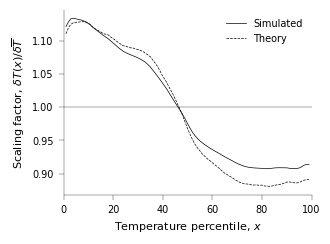

In [19]:
save_sf_theory_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average(sf_simulated, weights=lat_weights, axis=0), color='k',
           label='Simulated')
ax.plot(quant_plot, np.average(sf_theory, weights=lat_weights, axis=0), color='k', linestyle='--', label='Theory')
ax.legend()
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
ax.axhline(1, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)
if save_sf_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sf_theory_{region}_{season}.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)